In [1]:
import pandas as pd
import matplotlib.pyplot as plt

**<font size=5>Ⅰ数据预处理</font>**

<font size=4>1.读取数据</font>

In [2]:
filename = "2015O3data.csv"
data = pd.read_csv(filename, header = 0, encoding="utf-8")

<font size=4>2.查看数据</font>

In [3]:
data.dtypes

date           int64
hour           int64
O3           float64
O3_24h       float64
O3_8h        float64
O3_8h_24h    float64
dtype: object

In [4]:
data.shape

(8212, 6)

In [5]:
data.count()

date         8212
hour         8212
O3           8212
O3_24h       8212
O3_8h        8212
O3_8h_24h    8212
dtype: int64

In [6]:
data.describe()

,date,hour,O3,O3_24h,O3_8h,O3_8h_24h
count,8.212000e+03,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000
mean,2.015067e+07,11.462250,52.897224,109.132002,53.301875,91.991963
std,3.452091e+02,6.930324,45.960168,59.599868,41.482109,52.009482
min,2.015010e+07,0.000000,2.000000,5.000000,2.000000,4.000000
25%,2.015040e+07,5.000000,17.000000,60.000000,21.000000,49.000000
50%,2.015070e+07,11.000000,40.000000,103.000000,43.000000,86.000000
75%,2.015100e+07,18.000000,74.000000,152.000000,75.000000,130.000000
max,2.015123e+07,23.000000,277.000000,279.000000,246.000000,248.000000


<font size=4>3.时间的处理</font>

In [7]:
data["hournew"] = data["hour"].map(lambda x:("%02d")%x)

data["datetime"] = data["date"].map(str) + data["hournew"].map(str)

data["datetime"] = pd.to_datetime(data["datetime"], format="%Y%m%d%H")

In [8]:
data["year"] = pd.DatetimeIndex(data.datetime).year
data["month"] = pd.DatetimeIndex(data.datetime).month
data["day"] = pd.DatetimeIndex(data.datetime).day

In [9]:
data = data.drop(["date", "hournew"], axis=1)

In [10]:
data = data.set_index("datetime")
#存储索引，以便后期绘图
dataIndex = data.index

<font size=4>4.调整一下数据的位置</font>

In [11]:
orderlist = ["year", "month", "day", "hour", "O3", "O3_24h", "O3_8h", "O3_8h_24h"]
data = data[orderlist]
print(data.head())

                     year  month  day  hour    O3  O3_24h  O3_8h  O3_8h_24h
datetime                                                                   
2015-01-02 00:00:00  2015      1    2     0  40.0   103.0   43.0       86.0
2015-01-02 01:00:00  2015      1    2     1  11.0    47.0   11.0       36.0
2015-01-02 02:00:00  2015      1    2     2  10.0    47.0   11.0       36.0
2015-01-02 03:00:00  2015      1    2     3  13.0    47.0   11.0       36.0
2015-01-02 04:00:00  2015      1    2     4  15.0    47.0   11.0       36.0


<font size=4>5.查看原始数据</font>

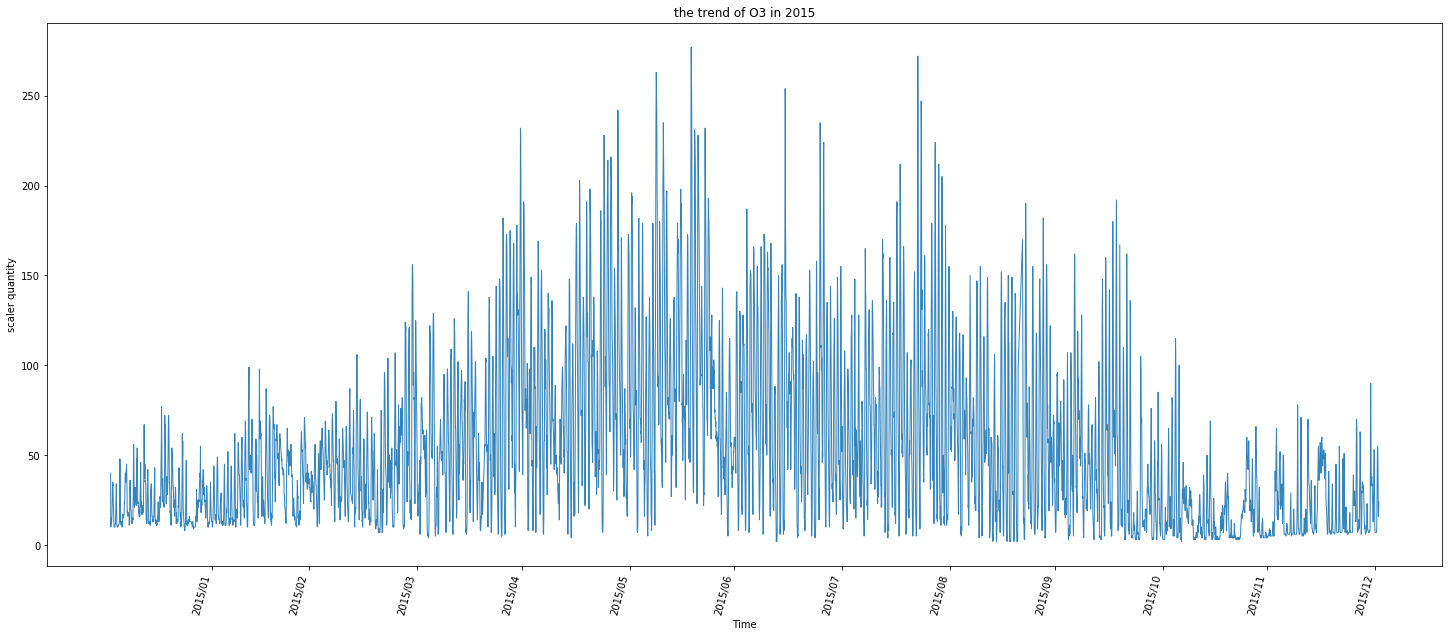

In [12]:
plt.figure(figsize=(25,10))
xticks = pd.date_range(start=dataIndex.min(), end = dataIndex.max(), freq="m")
plt.xticks(xticks, xticks.strftime("%Y/%m"), rotation=75, ha="right")
plt.plot(data["O3"], linewidth=1, alpha=0.9)
plt.xlabel("Time")
plt.ylabel("scaler quantity")
plt.title("the trend of O3 in 2015")
plt.show()

In [13]:
%matplotlib

Using matplotlib backend: Qt5Agg


**<font size=5>Ⅱ边缘权重因子</font>**

**<font size=4 color="blue">用于确定子时间序列的边界点</font>**

1. 首先要确定检测窗口的宽度，然后找到检测窗口中的最大值与最小值

In [86]:
#假设将检测窗口的宽度设置为24（即一天）
w = 168

先用一天的数据做一个实验

In [87]:
datatest = data[["O3"]]

In [88]:
datatest.head()

,O3
datetime,
2015-01-02 00:00:00,40.0
2015-01-02 01:00:00,11.0
2015-01-02 02:00:00,10.0
2015-01-02 03:00:00,13.0
2015-01-02 04:00:00,15.0


查看这一天的数据图像

In [89]:
datatestIndex = datatest.index

In [90]:
plt.figure(figsize=(25,10))
xticks = pd.date_range(start=datatestIndex.min(), end = datatestIndex.max(), freq="M")
plt.xticks(xticks, xticks.strftime("%Y/%m:%H"), rotation=75, ha="right")
plt.plot(datatest, linewidth=2, alpha=0.9)
plt.xlabel("Time")
plt.ylabel("scaler quantity")
plt.title("the trend of test O3 in 2015")
plt.show()

In [91]:
testarray = datatest.values

In [92]:
testarray.shape

(8212, 1)

In [93]:
wlist = []

对前w个数据和后w个数据即一个窗口单独处理

<font color="red">其实按理说，第一个点和最后一个数据|应该标为异常点</font>

In [94]:
forewindowarray = testarray[:w]

#计算第一个窗口的最大值、最小值和标准差
wmin = forewindowarray.min()
wmax = forewindowarray.max()
wstd = forewindowarray.std()

forepointnum = 0
forelist = []
for i in range(w):
    if forewindowarray[i] > wmax - wstd:
        forepointnum += 1
        forelist.append(i)
print("第一个窗口中候选异常数据有：", forepointnum, "个")
print("第一个窗口中的异常数据下标是:", forelist)

第一个窗口中候选异常数据有： 12 个
第一个窗口中的异常数据下标是: [53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]


对最后一个窗口做相同的处理

In [95]:
lastwindowarray = testarray[len(testarray) - w:]

#计算第一个窗口的最大值、最小值和标准差
wmin = lastwindowarray.min()
wmax = lastwindowarray.max()
wstd = lastwindowarray.std()

lastpointnum = 0
lastlist = []
for i in range(w):
    if lastwindowarray[i] > wmax - wstd:
        lastpointnum += 1
        lastlist.append(len(testarray) - w + i)
print("最后一个窗口中候选异常数据有：", lastpointnum, "个")
print("最后一个窗口中的异常数据下标是:", lastlist)

最后一个窗口中候选异常数据有： 3 个
最后一个窗口中的异常数据下标是: [8154, 8155, 8156]


对中间的元素进行统一的异常检测

In [96]:
import numpy as np

利用一个数组来存放异常点出现的次数

In [97]:
outlierarray = np.zeros_like(testarray)

定义一个函数用于异常点检测，当异常元素出现的时候，就存储下这个异常元素的下标，并加1.

In [98]:
def testOutlier(outlierarray, pointlist):
    for i in range(len(pointlist)):
        outlierarray[pointlist[i]] += 1
    return outlierarray

In [99]:
for i in range(1,len(testarray)-w):
    #将第i个元素到第i+w-1个元素记为一个检测窗口
    windowarray = testarray[i:i+w]
    #计算窗口的最大值、最小值和标准差
    wmin = windowarray.min()
    wmax = windowarray.max()
    wstd = windowarray.std()
    
    print("({:},{:}), min:{}, max:{}, std:{}".format(i, i+w-1, wmin, wmax, wstd))
    
    maxpoint = 0
    pointlist = []
    for j in range(len(windowarray)):
        
        if windowarray[j] >= wmax - wstd:
                maxpoint += 1
                pointlist.append(i+j)
    outlierarray = testOutlier(outlierarray,pointlist)
    print(maxpoint)
    print(pointlist)

(1,168), min:10.0, max:56.0, std:11.630030852512192
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(2,169), min:10.0, max:56.0, std:11.596894132255379
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(3,170), min:10.0, max:56.0, std:11.556495115954464
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(4,171), min:10.0, max:56.0, std:11.532782257979958
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(5,172), min:10.0, max:56.0, std:11.51835854697969
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(6,173), min:10.0, max:56.0, std:11.489489182640128
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(7,174), min:10.0, max:56.0, std:11.470445052127557
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(8,175), min:10.0, max:56.0, std:11.45153323265862
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 163, 164, 165]
(9,176), min:10.0, max:56.0, std:11.433381924094997
12
[53, 54, 94, 141, 142, 143, 144, 160, 162, 

(176,343), min:11.0, max:77.0, std:13.029791816189643
3
[209, 210, 324]
(177,344), min:11.0, max:77.0, std:13.523127026289481
4
[209, 210, 324, 344]
(178,345), min:11.0, max:77.0, std:13.850452484074498
5
[209, 210, 324, 344, 345]
(179,346), min:11.0, max:77.0, std:14.205338124656791
7
[209, 210, 323, 324, 344, 345, 346]
(180,347), min:11.0, max:77.0, std:14.48452801684433
8
[209, 210, 323, 324, 344, 345, 346, 347]
(181,348), min:11.0, max:77.0, std:14.724788929339715
8
[209, 210, 323, 324, 344, 345, 346, 347]
(182,349), min:11.0, max:77.0, std:14.848421585568158
8
[209, 210, 323, 324, 344, 345, 346, 347]
(183,350), min:11.0, max:77.0, std:14.88961533557096
8
[209, 210, 323, 324, 344, 345, 346, 347]
(184,351), min:11.0, max:77.0, std:14.901632059561422
8
[209, 210, 323, 324, 344, 345, 346, 347]
(185,352), min:11.0, max:77.0, std:14.900444376943444
8
[209, 210, 323, 324, 344, 345, 346, 347]
(186,353), min:11.0, max:77.0, std:14.886045556972578
8
[209, 210, 323, 324, 344, 345, 346, 347]


(301,468), min:10.0, max:77.0, std:16.063873885762646
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(302,469), min:10.0, max:77.0, std:16.106716110209284
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(303,470), min:10.0, max:77.0, std:16.163962008135677
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(304,471), min:9.0, max:77.0, std:16.204720624606338
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(305,472), min:9.0, max:77.0, std:16.23325929944425
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(306,473), min:8.0, max:77.0, std:16.26972790804487
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(307,474), min:8.0, max:77.0, std:16.30606063335608
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368, 369, 370, 459]
(308,475), min:8.0, max:77.0, std:16.334300783509768
14
[323, 324, 344, 345, 346, 347, 348, 365, 366, 367, 368,

(423,590), min:8.0, max:62.0, std:11.52803936538982
4
[459, 462, 576, 577]
(424,591), min:8.0, max:62.0, std:11.56808293540695
4
[459, 462, 576, 577]
(425,592), min:8.0, max:62.0, std:11.596605412195752
4
[459, 462, 576, 577]
(426,593), min:8.0, max:62.0, std:11.660901150694079
4
[459, 462, 576, 577]
(427,594), min:8.0, max:62.0, std:11.751007097285472
4
[459, 462, 576, 577]
(428,595), min:8.0, max:62.0, std:11.855599380799124
4
[459, 462, 576, 577]
(429,596), min:8.0, max:62.0, std:11.956785140009572
4
[459, 462, 576, 577]
(430,597), min:8.0, max:62.0, std:12.034658884064074
4
[459, 462, 576, 577]
(431,598), min:8.0, max:62.0, std:12.054038791644741
4
[459, 462, 576, 577]
(432,599), min:8.0, max:62.0, std:12.054614887227427
4
[459, 462, 576, 577]
(433,600), min:8.0, max:62.0, std:12.066530364829465
4
[459, 462, 576, 577]
(434,601), min:8.0, max:62.0, std:12.096193016297663
4
[459, 462, 576, 577]
(435,602), min:8.0, max:62.0, std:12.085415021248863
4
[459, 462, 576, 577]
(436,603), min

17
[595, 596, 664, 665, 666, 687, 688, 689, 690, 691, 692, 737, 738, 758, 759, 760, 761]
(595,762), min:10.0, max:52.0, std:11.271137864157037
17
[595, 596, 664, 665, 666, 687, 688, 689, 690, 691, 692, 737, 738, 758, 759, 760, 761]
(596,763), min:10.0, max:52.0, std:11.165408536597111
16
[596, 664, 665, 666, 687, 688, 689, 690, 691, 692, 737, 738, 758, 759, 760, 761]
(597,764), min:10.0, max:52.0, std:11.063628524755648
15
[664, 665, 666, 687, 688, 689, 690, 691, 692, 737, 738, 758, 759, 760, 761]
(598,765), min:10.0, max:52.0, std:10.9831542314013
14
[664, 665, 666, 687, 688, 689, 690, 691, 737, 738, 758, 759, 760, 761]
(599,766), min:10.0, max:52.0, std:10.967639474666301
14
[664, 665, 666, 687, 688, 689, 690, 691, 737, 738, 758, 759, 760, 761]
(600,767), min:10.0, max:52.0, std:10.979004907223354
14
[664, 665, 666, 687, 688, 689, 690, 691, 737, 738, 758, 759, 760, 761]
(601,768), min:10.0, max:52.0, std:10.994766264185957
14
[664, 665, 666, 687, 688, 689, 690, 691, 737, 738, 758, 75

[899, 900, 901, 902]
(763,930), min:10.0, max:99.0, std:19.66625950806479
4
[899, 900, 901, 902]
(764,931), min:10.0, max:99.0, std:19.692684817400096
4
[899, 900, 901, 902]
(765,932), min:10.0, max:99.0, std:19.710313465698604
4
[899, 900, 901, 902]
(766,933), min:10.0, max:99.0, std:19.72881534825017
4
[899, 900, 901, 902]
(767,934), min:10.0, max:99.0, std:19.748188010681268
4
[899, 900, 901, 902]
(768,935), min:10.0, max:99.0, std:19.754939069265323
4
[899, 900, 901, 902]
(769,936), min:10.0, max:99.0, std:19.754939069265323
4
[899, 900, 901, 902]
(770,937), min:10.0, max:99.0, std:19.748188010681268
4
[899, 900, 901, 902]
(771,938), min:10.0, max:99.0, std:19.754939069265323
4
[899, 900, 901, 902]
(772,939), min:10.0, max:99.0, std:19.761384818174378
4
[899, 900, 901, 902]
(773,940), min:10.0, max:99.0, std:19.773963618561876
4
[899, 900, 901, 902]
(774,941), min:10.0, max:99.0, std:19.79235229746884
4
[899, 900, 901, 902]
(775,942), min:10.0, max:99.0, std:19.770837589513743
4
[8

15
[979, 1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(980,1147), min:11.0, max:87.0, std:19.21273578306435
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(981,1148), min:11.0, max:87.0, std:19.20379334545327
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(982,1149), min:11.0, max:87.0, std:19.21305758156814
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(983,1150), min:11.0, max:87.0, std:19.253309047980615
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(984,1151), min:11.0, max:87.0, std:19.299376957915477
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(985,1152), min:11.0, max:87.0, std:19.380476148062606
14
[1016, 1017, 1018, 1019, 1039, 1040, 1041, 1042, 1043, 1065, 1066, 1067, 1068, 1069]
(986,1153), min:11.0, max:87.0, std:19.4934978112215

21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1282]
(1125,1292), min:10.0, max:71.0, std:16.530608548717424
21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1282]
(1126,1293), min:10.0, max:71.0, std:16.505612149396455
21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1282]
(1127,1294), min:10.0, max:71.0, std:16.49211314290462
21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1282]
(1128,1295), min:10.0, max:71.0, std:16.498398018844394
21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1282]
(1129,1296), min:10.0, max:71.0, std:16.49159323389618
21
[1160, 1161, 1162, 1163, 1186, 1250, 1251, 1252, 1253, 1254, 1255, 12

20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1465, 1466, 1467, 1468]
(1313,1480), min:10.0, max:73.0, std:14.488105020147733
20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1465, 1466, 1467, 1468]
(1314,1481), min:10.0, max:73.0, std:14.626034422785551
20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1465, 1466, 1467, 1468]
(1315,1482), min:10.0, max:73.0, std:14.735305095919841
20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1465, 1466, 1467, 1468]
(1316,1483), min:10.0, max:73.0, std:14.75794877868178
20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1465, 1466, 1467, 1468]
(1317,1484), min:10.0, max:73.0, std:14.705844733678708
20
[1392, 1393, 1394, 1395, 1415, 1416, 1417, 1418, 1438, 1439, 1440, 1441, 1442, 1462, 1463, 1464, 1

(1472,1639), min:10.0, max:106.0, std:21.712111387326924
7
[1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1473,1640), min:10.0, max:106.0, std:21.87406946514494
7
[1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1474,1641), min:10.0, max:106.0, std:22.07149278256443
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1475,1642), min:10.0, max:106.0, std:22.267592219755286
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1476,1643), min:10.0, max:106.0, std:22.376443314778626
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1477,1644), min:10.0, max:106.0, std:22.40715205989762
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1478,1645), min:10.0, max:106.0, std:22.36121137355869
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1479,1646), min:10.0, max:106.0, std:22.269904820503516
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1480,1647), min:10.0, max:106.0, std:22.192436014774074
8
[1581, 1582, 1616, 1617, 1618, 1619, 1620, 1621]
(1481,1648), min:10.0, max:106.0, std:22.103

(1645,1812), min:7.0, max:96.0, std:22.411104783798265
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1646,1813), min:7.0, max:96.0, std:22.35889237031233
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1647,1814), min:7.0, max:96.0, std:22.35889237031233
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1648,1815), min:7.0, max:96.0, std:22.36098320761719
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1649,1816), min:7.0, max:96.0, std:22.36458922472032
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1650,1817), min:7.0, max:96.0, std:22.375835281283855
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1651,1818), min:7.0, max:96.0, std:22.425800430381756
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1652,1819), min:7.0, max:96.0, std:22.48354147344694
11
[1688, 1780, 1781, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808]
(1653

[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1812,1979), min:9.0, max:124.0, std:29.925758476739787
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1813,1980), min:9.0, max:124.0, std:30.024194231136743
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1814,1981), min:9.0, max:124.0, std:30.126650649633778
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1815,1982), min:9.0, max:124.0, std:30.22494089579325
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1816,1983), min:9.0, max:124.0, std:30.324977707480407
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1817,1984), min:9.0, max:124.0, std:30.387374652399735
15
[1827, 1876, 1877, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1966, 1967, 1968, 1969, 1970]
(1818,1985

11
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2108]
(1963,2130), min:4.0, max:156.0, std:36.87717046535177
12
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2108, 2130]
(1964,2131), min:4.0, max:156.0, std:37.2262628107784
14
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2107, 2108, 2130, 2131]
(1965,2132), min:4.0, max:156.0, std:37.612717501626264
15
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2107, 2108, 2130, 2131, 2132]
(1966,2133), min:4.0, max:156.0, std:37.961825541097184
16
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2107, 2108, 2130, 2131, 2132, 2133]
(1967,2134), min:4.0, max:156.0, std:38.08793084679812
18
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2107, 2108, 2110, 2130, 2131, 2132, 2133, 2134]
(1968,2135), min:4.0, max:156.0, std:38.115578182287464
19
[1968, 1969, 1988, 1989, 1990, 1991, 1992, 1993, 2011, 2012, 2107, 2108, 2110, 2130, 2131, 2132, 2133, 2134, 2135]
(1969,2136

12
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295]
(2145,2312), min:5.0, max:126.0, std:29.850391671408733
12
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295]
(2146,2313), min:5.0, max:126.0, std:29.80143802934315
12
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295]
(2147,2314), min:6.0, max:126.0, std:29.758637320640304
12
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295]
(2148,2315), min:6.0, max:126.0, std:29.758799838038723
13
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295, 2315]
(2149,2316), min:6.0, max:126.0, std:29.78452890089203
14
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295, 2315, 2316]
(2150,2317), min:6.0, max:126.0, std:29.78397277083105
14
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271, 2272, 2273, 2274, 2295, 2315, 2316]
(2151,2318), min:6.0, max:126.0, std:29.74414648772842
14
[2227, 2248, 2249, 2250, 2251, 2252, 2270, 2271

(2311,2478), min:6.0, max:141.0, std:33.44515046414294
12
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379]
(2312,2479), min:6.0, max:141.0, std:33.66107374234411
13
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379, 2479]
(2313,2480), min:6.0, max:141.0, std:34.054109854159805
14
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379, 2479, 2480]
(2314,2481), min:6.0, max:141.0, std:34.54757340993343
15
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379, 2479, 2480, 2481]
(2315,2482), min:6.0, max:141.0, std:34.95948770928561
16
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379, 2479, 2480, 2481, 2482]
(2316,2483), min:6.0, max:141.0, std:35.046664712679764
17
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 2378, 2379, 2479, 2480, 2481, 2482, 2483]
(2317,2484), min:6.0, max:141.0, std:34.96545711999169
17
[2354, 2355, 2356, 2357, 2358, 2359, 2360, 2375, 2376, 2377, 237

30
[2481, 2482, 2524, 2544, 2545, 2546, 2547, 2548, 2549, 2567, 2568, 2569, 2570, 2588, 2589, 2590, 2591, 2592, 2593, 2611, 2612, 2613, 2614, 2615, 2633, 2634, 2635, 2636, 2637, 2638]
(2478,2645), min:5.0, max:182.0, std:50.74281977288413
30
[2481, 2482, 2524, 2544, 2545, 2546, 2547, 2548, 2549, 2567, 2568, 2569, 2570, 2588, 2589, 2590, 2591, 2592, 2593, 2611, 2612, 2613, 2614, 2615, 2633, 2634, 2635, 2636, 2637, 2638]
(2479,2646), min:5.0, max:182.0, std:50.90680782059501
30
[2481, 2482, 2524, 2544, 2545, 2546, 2547, 2548, 2549, 2567, 2568, 2569, 2570, 2588, 2589, 2590, 2591, 2592, 2593, 2611, 2612, 2613, 2614, 2615, 2633, 2634, 2635, 2636, 2637, 2638]
(2480,2647), min:5.0, max:182.0, std:51.097295799665844
31
[2481, 2482, 2524, 2544, 2545, 2546, 2547, 2548, 2549, 2567, 2568, 2569, 2570, 2588, 2589, 2590, 2591, 2592, 2593, 2611, 2612, 2613, 2614, 2615, 2633, 2634, 2635, 2636, 2637, 2638, 2639]
(2481,2648), min:5.0, max:182.0, std:51.19359036762211
31
[2481, 2482, 2524, 2544, 2545, 254

(2644,2811), min:7.0, max:232.0, std:50.02495833997366
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2645,2812), min:7.0, max:232.0, std:49.93366312287214
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2646,2813), min:7.0, max:232.0, std:49.95275403873566
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2647,2814), min:7.0, max:232.0, std:49.94178016346325
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2648,2815), min:7.0, max:232.0, std:49.84830588669231
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2649,2816), min:7.0, max:232.0, std:49.701127372272246
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2650,2817), min:7.0, max:232.0, std:49.52091337685528
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2651,2818), min:7.0, max:232.0, std:49.38599184461309
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2652,2819), min:7.0, max:232.0, std:49.22184115927444
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700]
(2653,2820), min:7.0, max:232.0, std:49.073213386824825
7
[2678, 2679, 2680, 2681, 2698, 2699, 2700

20
[2813, 2814, 2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2959, 2960, 2961, 2962]
(2811,2978), min:6.0, max:153.0, std:35.28002653214484
20
[2813, 2814, 2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2959, 2960, 2961, 2962]
(2812,2979), min:6.0, max:153.0, std:35.24810628386495
20
[2813, 2814, 2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2959, 2960, 2961, 2962]
(2813,2980), min:6.0, max:153.0, std:35.10017198551452
20
[2813, 2814, 2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2959, 2960, 2961, 2962]
(2814,2981), min:6.0, max:153.0, std:34.795478222108336
18
[2814, 2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2960, 2961, 2962]
(2815,2982), min:6.0, max:153.0, std:34.54994084941988
18
[2815, 2816, 2817, 2818, 2837, 2858, 2859, 2860, 2861, 2862, 2868, 2869, 2870, 2871, 2960, 2961, 2962, 2982]
(281

(2977,3144), min:4.0, max:203.0, std:49.64442122407581
23
[3023, 3024, 3025, 3026, 3027, 3028, 3044, 3045, 3046, 3047, 3048, 3049, 3088, 3089, 3090, 3091, 3110, 3111, 3112, 3113, 3114, 3115, 3116]
(2978,3145), min:4.0, max:203.0, std:49.56624212381492
23
[3023, 3024, 3025, 3026, 3027, 3028, 3044, 3045, 3046, 3047, 3048, 3049, 3088, 3089, 3090, 3091, 3110, 3111, 3112, 3113, 3114, 3115, 3116]
(2979,3146), min:4.0, max:203.0, std:49.54776742786871
23
[3023, 3024, 3025, 3026, 3027, 3028, 3044, 3045, 3046, 3047, 3048, 3049, 3088, 3089, 3090, 3091, 3110, 3111, 3112, 3113, 3114, 3115, 3116]
(2980,3147), min:4.0, max:203.0, std:49.55612177049343
23
[3023, 3024, 3025, 3026, 3027, 3028, 3044, 3045, 3046, 3047, 3048, 3049, 3088, 3089, 3090, 3091, 3110, 3111, 3112, 3113, 3114, 3115, 3116]
(2981,3148), min:4.0, max:203.0, std:49.64081730421434
23
[3023, 3024, 3025, 3026, 3027, 3028, 3044, 3045, 3046, 3047, 3048, 3049, 3088, 3089, 3090, 3091, 3110, 3111, 3112, 3113, 3114, 3115, 3116]
(2982,3149), mi

22
[3181, 3202, 3203, 3204, 3205, 3206, 3225, 3226, 3227, 3228, 3229, 3230, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3290, 3291, 3292]
(3144,3311), min:7.0, max:242.0, std:59.48013844411482
22
[3181, 3202, 3203, 3204, 3205, 3206, 3225, 3226, 3227, 3228, 3229, 3230, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3290, 3291, 3292]
(3145,3312), min:7.0, max:242.0, std:59.62453382638396
22
[3181, 3202, 3203, 3204, 3205, 3206, 3225, 3226, 3227, 3228, 3229, 3230, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3290, 3291, 3292]
(3146,3313), min:7.0, max:242.0, std:59.62969599822952
22
[3181, 3202, 3203, 3204, 3205, 3206, 3225, 3226, 3227, 3228, 3229, 3230, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3290, 3291, 3292]
(3147,3314), min:7.0, max:242.0, std:59.57330799060357
22
[3181, 3202, 3203, 3204, 3205, 3206, 3225, 3226, 3227, 3228, 3229, 3230, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3290, 3291, 3292]
(3148,3315), min:7.0, max:242.0, std:59.50629742394141
22
[3181, 3202, 3203, 3204, 3205, 3206, 3225,

(3310,3477), min:7.0, max:196.0, std:50.0659595404424
26
[3311, 3312, 3313, 3314, 3354, 3355, 3356, 3357, 3358, 3359, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3419, 3420, 3421, 3422, 3443, 3444, 3445, 3446, 3447]
(3311,3478), min:5.0, max:196.0, std:50.3007620883289
26
[3311, 3312, 3313, 3314, 3354, 3355, 3356, 3357, 3358, 3359, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3419, 3420, 3421, 3422, 3443, 3444, 3445, 3446, 3447]
(3312,3479), min:5.0, max:196.0, std:50.26676568495634
25
[3312, 3313, 3314, 3354, 3355, 3356, 3357, 3358, 3359, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3419, 3420, 3421, 3422, 3443, 3444, 3445, 3446, 3447]
(3313,3480), min:5.0, max:196.0, std:49.991895247324855
24
[3313, 3314, 3354, 3355, 3356, 3357, 3358, 3359, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3419, 3420, 3421, 3422, 3443, 3444, 3445, 3446, 3447]
(3314,3481), min:5.0, max:196.0, std:49.69135142805065
23
[3314, 3354, 3355, 3356, 3357, 3358, 3359, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3419, 3420, 3421

10
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3572, 3573, 3574]
(3477,3644), min:5.0, max:263.0, std:58.14038424404634
10
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3572, 3573, 3574]
(3478,3645), min:5.0, max:263.0, std:57.71216127189719
10
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3572, 3573, 3574]
(3479,3646), min:8.0, max:263.0, std:57.244708028098295
10
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3572, 3573, 3574]
(3480,3647), min:8.0, max:263.0, std:56.814049035431836
9
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3573, 3574]
(3481,3648), min:8.0, max:263.0, std:56.484473201654986
9
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3573, 3574]
(3482,3649), min:8.0, max:263.0, std:56.29422297906177
9
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3573, 3574]
(3483,3650), min:8.0, max:263.0, std:56.22110242850672
9
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3573, 3574]
(3484,3651), min:8.0, max:263.0, std:56.30723058604322
9
[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3573, 3574]
(3485,3652), min

(3643,3810), min:23.0, max:277.0, std:57.77065570611334
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3644,3811), min:22.0, max:277.0, std:58.166257027873584
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3645,3812), min:22.0, max:277.0, std:58.4967702535964
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3646,3813), min:22.0, max:277.0, std:58.798788059995445
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3647,3814), min:22.0, max:277.0, std:59.09931972397597
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3648,3815), min:22.0, max:277.0, std:59.397365700460114
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3649,3816), min:22.0, max:277.0, std:59.616014299831654
12
[3748, 3749, 3750, 3751, 3752, 3753, 3768, 3769, 3770, 3771, 3787, 3788]
(3650,3817), min:22.0, max:277.0, std:59.66692794379004
12
[3748, 3749, 3

11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3810,3977), min:5.0, max:232.0, std:49.589707973578165
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3811,3978), min:5.0, max:232.0, std:49.63934411459306
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3812,3979), min:5.0, max:232.0, std:49.56659059633486
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3813,3980), min:5.0, max:232.0, std:49.47293596645129
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3814,3981), min:5.0, max:232.0, std:49.32226043228007
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3815,3982), min:5.0, max:232.0, std:49.145495485079024
11
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3842, 3843, 3844, 3845]
(3816,3983), min:5.0, max:232.0, std:48.965783193499874
10
[3820, 3821, 3822, 3823, 3824, 3825, 3826, 3843, 3844, 3845]
(3817,3984), min:5.0, max:232.0, std:48.86773967277005
10


(3976,4143), min:6.0, max:187.0, std:45.69975587544019
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 4142]
(3977,4144), min:7.0, max:187.0, std:45.61087478982365
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 4142]
(3978,4145), min:7.0, max:187.0, std:45.41184014483598
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 4142]
(3979,4146), min:7.0, max:187.0, std:45.26329459490365
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 4142]
(3980,4147), min:7.0, max:187.0, std:45.164447804900064
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 4142]
(3981,4148), min:7.0, max:187.0, std:45.08601905501333
18
[4091, 4092, 4093, 4094, 4095, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4138, 4139, 4140, 4141, 414

47
[4142, 4143, 4144, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4187, 4188, 4189, 4190, 4191, 4192, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4307, 4308, 4309]
(4143,4310), min:2.0, max:173.0, std:49.536489619823435
47
[4143, 4144, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4187, 4188, 4189, 4190, 4191, 4192, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4307, 4308, 4309, 4310]
(4144,4311), min:2.0, max:173.0, std:49.429774219240365
46
[4144, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4187, 4188, 4189, 4190, 4191, 4192, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4307, 4308, 4309, 4310]
(4145,4312), min:2.0, max:173.0, std

(4309,4476), min:4.0, max:254.0, std:50.64572795890615
3
[4354, 4355, 4356]
(4310,4477), min:4.0, max:254.0, std:50.61194087044548
3
[4354, 4355, 4356]
(4311,4478), min:4.0, max:254.0, std:50.65296286884204
3
[4354, 4355, 4356]
(4312,4479), min:4.0, max:254.0, std:50.793019240555374
3
[4354, 4355, 4356]
(4313,4480), min:4.0, max:254.0, std:50.94573693887348
3
[4354, 4355, 4356]
(4314,4481), min:4.0, max:254.0, std:51.008963909228456
3
[4354, 4355, 4356]
(4315,4482), min:4.0, max:254.0, std:50.97695085173876
3
[4354, 4355, 4356]
(4316,4483), min:4.0, max:254.0, std:50.92836237128445
3
[4354, 4355, 4356]
(4317,4484), min:4.0, max:254.0, std:50.89160260219265
3
[4354, 4355, 4356]
(4318,4485), min:4.0, max:254.0, std:50.80213683917541
3
[4354, 4355, 4356]
(4319,4486), min:4.0, max:254.0, std:50.65695080884195
3
[4354, 4355, 4356]
(4320,4487), min:4.0, max:254.0, std:50.45745946259583
3
[4354, 4355, 4356]
(4321,4488), min:4.0, max:254.0, std:50.24766750376739
3
[4354, 4355, 4356]
(4322,4489

10
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598, 4599]
(4476,4643), min:4.0, max:235.0, std:55.49541582618413
10
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598, 4599]
(4477,4644), min:4.0, max:235.0, std:55.47453726077444
10
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598, 4599]
(4478,4645), min:4.0, max:235.0, std:55.35741423384583
10
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598, 4599]
(4479,4646), min:4.0, max:235.0, std:55.18325993334164
10
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598, 4599]
(4480,4647), min:4.0, max:235.0, std:54.94903328088131
9
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598]
(4481,4648), min:4.0, max:235.0, std:54.77248830182214
9
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598]
(4482,4649), min:4.0, max:235.0, std:54.67497985933829
9
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598]
(4483,4650), min:4.0, max:235.0, std:54.66729890904926
9
[4571, 4572, 4573, 4574, 4575, 4595, 4596, 4597, 4598]
(4484,4651),

(4642,4809), min:9.0, max:155.0, std:39.45717588400741
26
[4642, 4643, 4644, 4645, 4646, 4669, 4670, 4671, 4689, 4690, 4691, 4692, 4693, 4694, 4712, 4713, 4714, 4715, 4716, 4785, 4786, 4787, 4788, 4789, 4790, 4809]
(4643,4810), min:9.0, max:155.0, std:39.64132298976265
26
[4643, 4644, 4645, 4646, 4669, 4670, 4671, 4689, 4690, 4691, 4692, 4693, 4694, 4712, 4713, 4714, 4715, 4716, 4785, 4786, 4787, 4788, 4789, 4790, 4809, 4810]
(4644,4811), min:9.0, max:155.0, std:39.476633850689524
26
[4644, 4645, 4646, 4669, 4670, 4671, 4689, 4690, 4691, 4692, 4693, 4694, 4712, 4713, 4714, 4715, 4716, 4785, 4786, 4787, 4788, 4789, 4790, 4809, 4810, 4811]
(4645,4812), min:9.0, max:155.0, std:39.04565725327384
25
[4645, 4646, 4669, 4670, 4671, 4689, 4690, 4691, 4692, 4693, 4694, 4712, 4713, 4714, 4715, 4716, 4785, 4786, 4787, 4788, 4789, 4790, 4809, 4810, 4811]
(4646,4813), min:9.0, max:155.0, std:38.67464144832454
23
[4646, 4669, 4670, 4671, 4689, 4690, 4691, 4692, 4693, 4694, 4712, 4713, 4714, 4715, 47

16
[4809, 4810, 4811, 4837, 4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4809,4976), min:5.0, max:165.0, std:37.575621031705744
16
[4809, 4810, 4811, 4837, 4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4810,4977), min:5.0, max:165.0, std:37.217277017761255
15
[4810, 4811, 4837, 4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4811,4978), min:5.0, max:165.0, std:36.744781896190915
13
[4811, 4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4812,4979), min:5.0, max:165.0, std:36.46034834081796
12
[4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4813,4980), min:5.0, max:165.0, std:36.444112386836906
12
[4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4814,4981), min:5.0, max:165.0, std:36.474276883163284
12
[4879, 4880, 4881, 4882, 4883, 4884, 4906, 4907, 4928, 4929, 4930, 4931]
(4815,4982), min:5.0, max:165.0, std:36.48351317070005
12
[48

(4975,5142), min:4.0, max:212.0, std:54.855866593950026
24
[4999, 5000, 5001, 5002, 5003, 5046, 5047, 5048, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5115, 5116, 5117, 5118, 5119, 5139, 5140, 5141, 5142]
(4976,5143), min:4.0, max:212.0, std:55.07883155675687
24
[4999, 5000, 5001, 5002, 5003, 5046, 5047, 5048, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5115, 5116, 5117, 5118, 5119, 5139, 5140, 5141, 5142]
(4977,5144), min:4.0, max:212.0, std:55.20588879198419
24
[4999, 5000, 5001, 5002, 5003, 5046, 5047, 5048, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5115, 5116, 5117, 5118, 5119, 5139, 5140, 5141, 5142]
(4978,5145), min:4.0, max:212.0, std:55.22334444878219
24
[4999, 5000, 5001, 5002, 5003, 5046, 5047, 5048, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5115, 5116, 5117, 5118, 5119, 5139, 5140, 5141, 5142]
(4979,5146), min:4.0, max:212.0, std:55.212129249557485
24
[4999, 5000, 5001, 5002, 5003, 5046, 5047, 5048, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5115, 5116, 5117, 5118, 5119, 5139, 5

6
[5236, 5237, 5238, 5258, 5259, 5260]
(5142,5309), min:5.0, max:272.0, std:56.33592423247341
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5143,5310), min:5.0, max:272.0, std:56.07613435667401
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5144,5311), min:5.0, max:272.0, std:55.840728264471764
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5145,5312), min:5.0, max:272.0, std:55.67058216707331
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5146,5313), min:5.0, max:272.0, std:55.62858564457959
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5147,5314), min:5.0, max:272.0, std:55.62636403076735
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5148,5315), min:5.0, max:272.0, std:55.62134596523288
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5149,5316), min:5.0, max:272.0, std:55.61329337436609
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5150,5317), min:5.0, max:272.0, std:55.596001575261354
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5151,5318), min:5.0, max:272.0, std:55.593060717533
6
[5236, 5237, 5238, 5258, 5259, 5260]
(5152,5319), min:5.0,

(5308,5475), min:11.0, max:224.0, std:54.119827995965814
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5309,5476), min:11.0, max:224.0, std:54.050523049736654
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5310,5477), min:11.0, max:224.0, std:53.99459029287741
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5311,5478), min:11.0, max:224.0, std:53.974246136761806
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5312,5479), min:11.0, max:224.0, std:54.06747032910931
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5313,5480), min:11.0, max:224.0, std:54.193930540479386
17
[5328, 5329, 5330, 5347, 5348, 5349, 5350, 5368, 5369, 5370, 5371, 5385, 5386, 5387, 5388, 5389, 5411]
(5314,5481), min:11.0, m

22
[5479, 5480, 5481, 5482, 5502, 5503, 5524, 5525, 5526, 5568, 5569, 5570, 5571, 5615, 5616, 5617, 5618, 5619, 5638, 5639, 5640, 5641]
(5475,5642), min:4.0, max:155.0, std:39.59800077339048
23
[5479, 5480, 5481, 5482, 5502, 5503, 5524, 5525, 5526, 5568, 5569, 5570, 5571, 5615, 5616, 5617, 5618, 5619, 5638, 5639, 5640, 5641, 5642]
(5476,5643), min:4.0, max:155.0, std:39.67509012416411
23
[5479, 5480, 5481, 5482, 5502, 5503, 5524, 5525, 5526, 5568, 5569, 5570, 5571, 5615, 5616, 5617, 5618, 5619, 5638, 5639, 5640, 5641, 5642]
(5477,5644), min:4.0, max:155.0, std:39.65949707972581
23
[5479, 5480, 5481, 5482, 5502, 5503, 5524, 5525, 5526, 5568, 5569, 5570, 5571, 5615, 5616, 5617, 5618, 5619, 5638, 5639, 5640, 5641, 5642]
(5478,5645), min:4.0, max:155.0, std:39.549518316826195
23
[5479, 5480, 5481, 5482, 5502, 5503, 5524, 5525, 5526, 5568, 5569, 5570, 5571, 5615, 5616, 5617, 5618, 5619, 5638, 5639, 5640, 5641, 5642]
(5479,5646), min:4.0, max:155.0, std:39.41275814422466
23
[5479, 5480, 5481

(5641,5808), min:2.0, max:152.0, std:41.50921953159863
26
[5641, 5642, 5661, 5662, 5663, 5664, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5774, 5775, 5776, 5777, 5778, 5779, 5797, 5798, 5799, 5800, 5801, 5802, 5803]
(5642,5809), min:2.0, max:152.0, std:41.211094051956245
25
[5642, 5661, 5662, 5663, 5664, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5774, 5775, 5776, 5777, 5778, 5779, 5797, 5798, 5799, 5800, 5801, 5802, 5803]
(5643,5810), min:2.0, max:152.0, std:41.05676368623999
24
[5661, 5662, 5663, 5664, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5774, 5775, 5776, 5777, 5778, 5779, 5797, 5798, 5799, 5800, 5801, 5802, 5803]
(5644,5811), min:2.0, max:152.0, std:41.08558762150155
24
[5661, 5662, 5663, 5664, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5774, 5775, 5776, 5777, 5778, 5779, 5797, 5798, 5799, 5800, 5801, 5802, 5803]
(5645,5812), min:2.0, max:152.0, std:41.19927264661328
24
[5661, 5662, 5663, 5664, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5774, 5775, 5776, 5777, 5778, 5779, 5797, 57

21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5956, 5957, 5958, 5959]
(5808,5975), min:2.0, max:190.0, std:52.08999243144441
21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5956, 5957, 5958, 5959]
(5809,5976), min:2.0, max:190.0, std:52.05068194218265
21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5956, 5957, 5958, 5959]
(5810,5977), min:2.0, max:190.0, std:52.041192135219916
21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5956, 5957, 5958, 5959]
(5811,5978), min:2.0, max:190.0, std:52.099328156235046
21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5956, 5957, 5958, 5959]
(5812,5979), min:2.0, max:190.0, std:52.12939018037935
21
[5820, 5821, 5822, 5844, 5845, 5866, 5867, 5868, 5888, 5889, 5907, 590

(5974,6141), min:4.0, max:182.0, std:41.022254465040774
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5975,6142), min:4.0, max:182.0, std:40.90457784134539
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5976,6143), min:4.0, max:182.0, std:40.92198441066337
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5977,6144), min:4.0, max:182.0, std:40.94202137448791
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5978,6145), min:4.0, max:182.0, std:40.890905893697884
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5979,6146), min:4.0, max:182.0, std:40.753204299960096
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5980,6147), min:4.0, max:182.0, std:40.55668073602995
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 6047]
(5981,6148), min:4.0, max:182.0, std:40.314737079555044
11
[5999, 6000, 6020, 6021, 6022, 6023, 6024, 6044, 6045, 6046, 60

6
[6226, 6227, 6228, 6229, 6230, 6274]
(6141,6308), min:3.0, max:162.0, std:35.82036181528923
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6142,6309), min:3.0, max:162.0, std:35.88663917948628
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6143,6310), min:3.0, max:162.0, std:35.91885854384811
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6144,6311), min:3.0, max:162.0, std:35.93352351558219
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6145,6312), min:3.0, max:162.0, std:35.92833278029864
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6146,6313), min:3.0, max:162.0, std:35.918767300503994
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6147,6314), min:3.0, max:162.0, std:35.909772528359866
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6148,6315), min:3.0, max:162.0, std:35.94356118165674
6
[6226, 6227, 6228, 6229, 6230, 6274]
(6149,6316), min:3.0, max:162.0, std:36.009836127126356
7
[6226, 6227, 6228, 6229, 6230, 6231, 6274]
(6150,6317), min:3.0, max:162.0, std:36.062280291285745
7
[6226, 6227, 6228, 6229, 6230, 6231, 6274]
(6151

(6307,6474), min:3.0, max:180.0, std:42.34129866409813
12
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474]
(6308,6475), min:3.0, max:180.0, std:43.23489235501938
13
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475]
(6309,6476), min:3.0, max:180.0, std:43.70544337832178
14
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475, 6476]
(6310,6477), min:3.0, max:180.0, std:43.79085030016359
14
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475, 6476]
(6311,6478), min:3.0, max:180.0, std:43.763526820423245
14
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475, 6476]
(6312,6479), min:3.0, max:180.0, std:43.750095561929975
14
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475, 6476]
(6313,6480), min:3.0, max:180.0, std:43.75113053285017
14
[6403, 6404, 6424, 6425, 6426, 6427, 6449, 6450, 6471, 6472, 6473, 6474, 6475, 6476]
(6314,6481), mi

14
[6473, 6474, 6475, 6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568, 6569]
(6474,6641), min:3.0, max:192.0, std:49.961139944312194
13
[6474, 6475, 6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568, 6569]
(6475,6642), min:3.0, max:192.0, std:49.01490905350952
12
[6475, 6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568, 6569]
(6476,6643), min:3.0, max:192.0, std:48.22193906041141
10
[6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568]
(6477,6644), min:3.0, max:192.0, std:47.76311799662619
10
[6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568]
(6478,6645), min:3.0, max:192.0, std:47.682677725795145
10
[6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568]
(6479,6646), min:3.0, max:192.0, std:47.759171439972164
10
[6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568]
(6480,6647), min:3.0, max:192.0, std:47.83534470100951
10
[6494, 6495, 6496, 6497, 6498, 6518, 6519, 6566, 6567, 6568]
(6481,6648), min:3.0, max:192.0, std:47.911666

(6640,6807), min:3.0, max:105.0, std:23.21848557857205
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6641,6808), min:3.0, max:105.0, std:23.229039877937137
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6642,6809), min:3.0, max:105.0, std:23.250115816647632
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6643,6810), min:3.0, max:105.0, std:23.26627801046651
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6644,6811), min:3.0, max:105.0, std:23.27729467877138
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6645,6812), min:3.0, max:105.0, std:23.288300049975458
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6646,6813), min:3.0, max:105.0, std:23.28830004997546
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6647,6814), min:3.0, max:105.0, std:23.293926271322036
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6648,6815), min:3.0, max:105.0, std:23.299549613419757
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6649,6816), min:3.0, max:105.0, std:23.299549613419757
6
[6659, 6660, 6661, 6662, 6663, 6777]
(6650,6817), min:3.0, max:105.0, std:23.29954961341975

9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6807,6974), min:2.0, max:115.0, std:25.976646039390502
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6808,6975), min:2.0, max:115.0, std:25.927663387615485
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6809,6976), min:2.0, max:115.0, std:25.877984234232983
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6810,6977), min:2.0, max:115.0, std:25.82276981192446
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6811,6978), min:2.0, max:115.0, std:25.76934966362496
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6812,6979), min:2.0, max:115.0, std:25.71744290031701
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6813,6980), min:2.0, max:115.0, std:25.660083969017954
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6814,6981), min:2.0, max:115.0, std:25.601371773364107
9
[6888, 6889, 6890, 6891, 6892, 6912, 6913, 6914, 6915]
(6815,6982), min:2.0, max:115.0, std:25.54

(6973,7140), min:3.0, max:69.0, std:14.068647245469636
5
[7110, 7111, 7112, 7113, 7114]
(6974,7141), min:3.0, max:69.0, std:14.069966838508707
5
[7110, 7111, 7112, 7113, 7114]
(6975,7142), min:3.0, max:69.0, std:14.07069835346473
5
[7110, 7111, 7112, 7113, 7114]
(6976,7143), min:3.0, max:69.0, std:14.064768335572873
5
[7110, 7111, 7112, 7113, 7114]
(6977,7144), min:3.0, max:69.0, std:14.065318752519522
5
[7110, 7111, 7112, 7113, 7114]
(6978,7145), min:3.0, max:69.0, std:14.056916566042185
5
[7110, 7111, 7112, 7113, 7114]
(6979,7146), min:3.0, max:69.0, std:14.04340130386531
5
[7110, 7111, 7112, 7113, 7114]
(6980,7147), min:3.0, max:69.0, std:14.009593408910666
5
[7110, 7111, 7112, 7113, 7114]
(6981,7148), min:3.0, max:69.0, std:13.990941959571547
4
[7111, 7112, 7113, 7114]
(6982,7149), min:3.0, max:69.0, std:13.978421173487416
4
[7111, 7112, 7113, 7114]
(6983,7150), min:3.0, max:69.0, std:13.972397473463978
4
[7111, 7112, 7113, 7114]
(6984,7151), min:3.0, max:69.0, std:13.9649047887780

8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7140,7307), min:3.0, max:40.0, std:8.933776260722224
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7141,7308), min:3.0, max:40.0, std:8.945695879764894
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7142,7309), min:3.0, max:40.0, std:8.959231089330052
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7143,7310), min:3.0, max:40.0, std:8.969760154107924
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7144,7311), min:3.0, max:40.0, std:8.980229528931332
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7145,7312), min:3.0, max:40.0, std:8.986760780785575
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7146,7313), min:3.0, max:40.0, std:8.99552672909079
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7147,7314), min:3.0, max:40.0, std:8.991285699910495
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7148,7315), min:3.0, max:40.0, std:8.991285699910495
8
[7216, 7217, 7229, 7230, 7231, 7232, 7233, 7234]
(7149

(7306,7473), min:3.0, max:66.0, std:16.87411709288516
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7307,7474), min:3.0, max:66.0, std:16.87411709288516
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7308,7475), min:3.0, max:66.0, std:16.867572061351865
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7309,7476), min:3.0, max:66.0, std:16.867572061351865
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7310,7477), min:4.0, max:66.0, std:16.86102238785415
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7311,7478), min:4.0, max:66.0, std:16.86102238785415
17
[7360, 7361, 7362, 7363, 7371, 7372, 7373, 7374, 7375, 7376, 7418, 7419, 7420, 7421, 7422, 7423, 7424]
(7312,7479), min:4.0, max:66.0, std:16

11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7473,7640), min:4.0, max:65.0, std:15.561376133047972
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7474,7641), min:4.0, max:65.0, std:15.552648816329699
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7475,7642), min:4.0, max:65.0, std:15.543907481944693
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7476,7643), min:4.0, max:65.0, std:15.531344030453072
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7477,7644), min:4.0, max:65.0, std:15.518749860160202
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7478,7645), min:4.0, max:65.0, std:15.499611398829948
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7479,7646), min:4.0, max:65.0, std:15.471884703223498
11
[7550, 7551, 7552, 7553, 7554, 7555, 7575, 7576, 7577, 7578, 7598]
(7480,7647), min:4.0, max:65.0, std:15.451857014743622


(7639,7806), min:5.0, max:78.0, std:17.802200198742284
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7640,7807), min:5.0, max:78.0, std:17.92272777560289
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7641,7808), min:5.0, max:78.0, std:18.06962472959748
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7642,7809), min:5.0, max:78.0, std:18.25611346521694
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7643,7810), min:5.0, max:78.0, std:18.42418640920868
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7644,7811), min:5.0, max:78.0, std:18.57962178090668
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7645,7812), min:5.0, max:78.0, std:18.740254459003715
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7646,7813), min:5.0, max:78.0, std:18.86281536705029
10
[7691, 7692, 7710, 7711, 7712, 7752, 7753, 7754, 7755, 7756]
(7647,7814), min:5.0, max:78.0, std:18.922227710568652

46
[7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7917, 7939, 7940, 7941, 7964, 7965, 7966]
(7806,7973), min:6.0, max:60.0, std:18.56252839236779
46
[7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7917, 7939, 7940, 7941, 7964, 7965, 7966, 7973]
(7807,7974), min:6.0, max:60.0, std:18.56252839236779
46
[7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7917, 7939, 7940, 7941, 7964, 7965, 7966, 7973, 7974]
(7808,7975), min:6.0, max:60.0, std:18.5063726230830

(7972,8139), min:6.0, max:70.0, std:15.162291689771513
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7973,8140), min:6.0, max:70.0, std:15.120036525589065
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7974,8141), min:6.0, max:70.0, std:14.942477574164927
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7975,8142), min:6.0, max:70.0, std:14.807375246072633
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7976,8143), min:6.0, max:70.0, std:14.720399359831415
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7977,8144), min:6.0, max:70.0, std:14.70098677600278
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7978,8145), min:6.0, max:70.0, std:14.724838256429322
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7979,8146), min:6.0, max:70.0, std:14.732935284123387
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7980,8147), min:6.0, max:70.0, std:14.732935284123386
8
[8056, 8057, 8058, 8059, 8060, 8082, 8083, 8084]
(7981,8148), min:6.0, max:70.0, std:14.73677656

In [100]:
outlierarray

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

利用np.where函数，查找异常数据对应的下标

In [101]:
outlierIndex = np.where(outlierarray > 10)[0]

In [102]:
outlierIndex

array([  53,   54,   94, ..., 8154, 8155, 8156], dtype=int64)

找到用于分隔的边缘点，存储在borderlist列表中，其中每个异常序列段存储为其中的一个小列表

In [103]:
borderlist = []

In [104]:
i = 0

In [105]:
while i < len(outlierIndex):
    
    lennum = 0
    sublist = [outlierIndex[i]]
    
    for j in range(i+1, len(outlierIndex)):
        if outlierIndex[j] == outlierIndex[i] + lennum + 1:
            lennum += 1
            sublist.append(outlierIndex[j])
            continue
        else:
            break
    
    borderlist.append(sublist)
    if lennum > 0:
        i = i + lennum + 1
    else:
        i += 1
    print(i)

2
3
7
8
12
13
16
18
23
29
34
35
36
37
39
43
47
54
58
62
64
69
75
81
87
91
94
98
105
115
127
128
141
150
152
155
160
170
179
180
181
182
187
193
199
206
211
212
213
218
221
227
233
237
241
243
247
255
257
261
264
271
276
282
288
296
304
305
308
314
319
320
322
329
334
339
342
350
354
360
365
372
375
377
378
383
390
395
401
407
409
414
418
423
428
435
441
445
452
456
461
467
476
479
483
489
496
500
505
508
516
522
524
528
529
535
541
545
552
561
565
570
575
580
588
594
602
607
616
624
632
638
648
659
666
670
678
682
683
686
690
696
697
700
708
714
719
724
731
736
739
745
750
756
759
762
768
771
777
785
787
795
798
805
810
814
819
823
826
830
834
839
842
848
851
855
859
863
868
875
880
885
892
893
899
907
911
912
918
925
927
934
938
941
946
952
954
955
956
961
963
966
970
975
979
985
990
994
999
1002
1007
1011
1013
1014
1017
1022
1026
1028
1029
1033
1038
1040
1046
1057
1064
1066
1073
1079
1083
1084
1086
1089
1095
1099
1109
1131
1138
1139
1140
1143
1146
1149
1154
1158
1161


In [106]:
borderlist

[[53, 54],
 [94],
 [141, 142, 143, 144],
 [160],
 [162, 163, 164, 165],
 [187],
 [209, 210, 211],
 [323, 324],
 [344, 345, 346, 347, 348],
 [365, 366, 367, 368, 369, 370],
 [387, 388, 389, 390, 391],
 [459],
 [462],
 [482],
 [576, 577],
 [594, 595, 596, 597],
 [664, 665, 666, 667],
 [686, 687, 688, 689, 690, 691, 692],
 [736, 737, 738, 739],
 [758, 759, 760, 761],
 [782, 783],
 [804, 805, 806, 807, 808],
 [827, 828, 829, 830, 831, 832],
 [850, 851, 852, 853, 854, 855],
 [875, 876, 877, 878, 879, 880],
 [899, 900, 901, 902],
 [972, 973, 974],
 [1016, 1017, 1018, 1019],
 [1038, 1039, 1040, 1041, 1042, 1043, 1044],
 [1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073],
 [1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096],
 [1100],
 [1109,
  1110,
  1111,
  1112,
  1113,
  1114,
  1115,
  1116,
  1117,
  1118,
  1119,
  1120,
  1121],
 [1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167],
 [1172, 1173],
 [1177, 1178, 1179],
 [1184, 1185, 1186, 1187, 1188],
 [

In [107]:
for sublist in borderlist:
    outlier = datatest.iloc[sublist]
    plt.plot(outlier, color="red", linewidth=4, alpha=0.5)